In [86]:
using PyPlot, Statistics

In [87]:
using DataFrames, CSV

In [88]:
data_path = "../cmip5_gmst.csv"
data = CSV.read(data_path);

time = data[:, 2];
gmst = Array(data[:, 3:end]);
gmst[ismissing.(gmst)] .= NaN;

In [89]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/plotting.jl");
include("../src/defaults.jl");

### Reproduce DICE2013r temperature forecast for stylized RCP8.5 forcing

In [90]:
Δt = 5.

RCP85_model = ClimateModel(t = collect(2020:Δt:2200.), dt=Δt);
RCP85_model.economics.baseline_emissions = baseline_emissions(t::Array{Float64,1}, q0, 4.75, 2100., 2100.);

model = ClimateModel(t = collect(2020:Δt:2200.), dt=Δt);
model.economics.baseline_emissions = baseline_emissions(t);

In [91]:
F2xCO2 = 3.8
η = 2.9

ζ1 = 0.098
ζ2 = F2xCO2/η
ζ3 = 0.088
ζ4 = 0.025

β = β
λ = ζ2

t = RCP85_model.domain
F = FCO₂_baseline(RCP85_model)/sec_per_year

T = zeros(size(t))
T_LO = zeros(size(t))

for i = 1:length(RCP85_model.domain)-1
    T[i+1] = T[i] + ζ1*(F[i] - ζ2*T[i] - ζ3*(T[i] - T_LO[i]))
    T_LO[i+1] = T_LO[i] + ζ4*(T[i] - T_LO[i])
end

T_RCP85 = deepcopy(T)
T_LO_RCP85  = deepcopy(T_LO)

T = zeros(size(t))
T_LO = zeros(size(t))
F = FCO₂_baseline(model)/sec_per_year

for i = 1:length(RCP85_model.domain)-1
    T[i+1] = T[i] + ζ1*(F[i] - ζ2*T[i] - ζ3*(T[i] - T_LO[i]))
    T_LO[i+1] = T_LO[i] + ζ4*(T[i] - T_LO[i])
end

### Make plot of comparison to RCP8.5

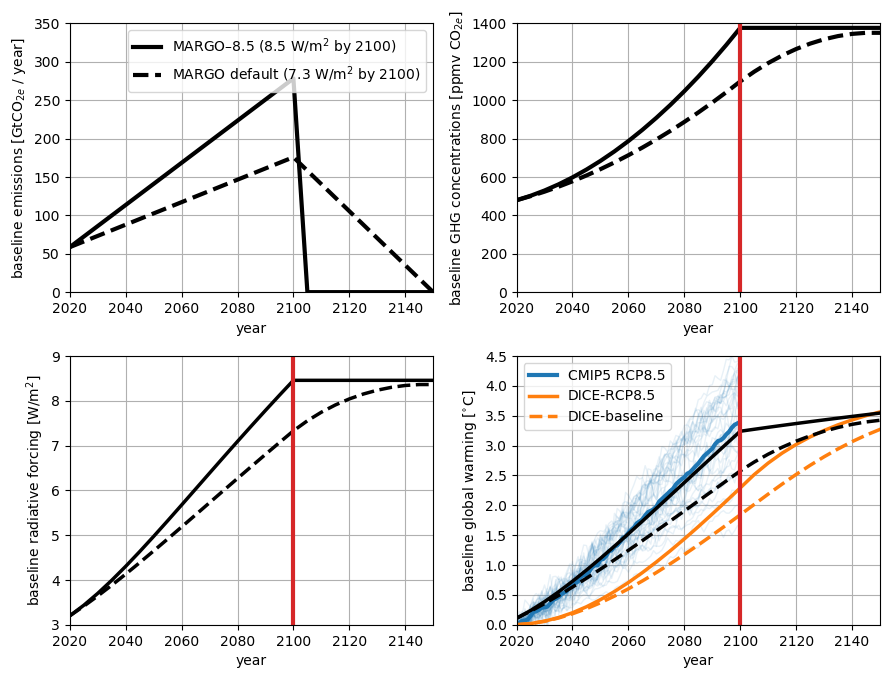

8.455142007641102
8.361028832768607


In [92]:
figure(figsize=(9,7))

subplot(2,2,4)

for i=1:40
    plot(time, gmst[:, i], "C0-", lw=1., alpha=0.1)
end
plot(time, mean(gmst[:, :], dims=2), "C0-")
plot([],[],"C0-", label="CMIP5 RCP8.5")

plot(t, T_RCP85, "C1-", lw=2.5, label="DICE-RCP8.5")
plot(t, T, "C1--", lw=2.5, label="DICE-baseline")
println(maximum(FCO₂_baseline(RCP85_model)/sec_per_year .+ 3.0))

plot(RCP85_model.domain, δT(RCP85_model).-δT_init, lw=2.5, "k-")
plot(model.domain, δT(model).-δT_init, lw=2.5, "k--")
println(maximum(FCO₂(model)/sec_per_year .+ 3.0))
xlim(2020, 2150)
ylim([0,4.5])
plot([2100, 2100], [0, 4.5], "C3-")
grid(true)
legend()
ylabel(L"baseline global warming [$^{\circ}$C]")
xlabel("year")

subplot(2,2,3)
plot(RCP85_model.domain, FCO₂(RCP85_model)/sec_per_year .+ 3.0, lw=2.5, "k-")
plot(model.domain, FCO₂(model)/sec_per_year .+ 3.0, lw=2.5, "k--")
plot([2100, 2100], [3.0, 10], "C3-")
ylim([3, 9])
xlim(2020, 2150)
grid(true)
ylabel(L"baseline radiative forcing [W/m$^{2}$]")
xlabel("year")

subplot(2,2,2)
plot(RCP85_model.domain, CO₂(RCP85_model), "k-")
plot(model.domain, CO₂(model), "k--")
plot([2100, 2100], [0, 1400], "C3-")
ylim([0, 1400])
xlim(2020, 2150)
grid(true)
ylabel(L"baseline GHG concentrations [ppmv CO$_{2e}$]")
xlabel("year")

subplot(2,2,1)
plot(RCP85_model.domain, ppm_to_GtCO2(RCP85_model.economics.baseline_emissions), "k-", label=L"MARGO–8.5 (8.5 W/m$^{2}$ by 2100)")
plot(model.domain, ppm_to_GtCO2(model.economics.baseline_emissions), "k--", label=L"MARGO default (7.3 W/m$^{2}$ by 2100)")
ylim([0, 350])
xlim(2020, 2150)
grid(true)
legend()
ylabel(L"baseline emissions [GtCO$_{2e}$ / year]")
xlabel("year")

tight_layout()
savefig("../figures/CMIP5_and_DICE_validation.png", dpi=200, bbox_inches="tight")